# Exploratory Data Analysis

In [33]:
# import neccesary libaries to used
import os
import collections
import copy
import re
import string
import time

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
import warnings
from pathlib import Path

from nltk.corpus import stopwords
from nltk.util import ngrams
from yellowbrick.target import class_balance

# Ignore font-related warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'  # Specify a fallback font
plt.rcParams['font.family'] = 'sans-serif'  # Fallback to sans-serif if the desired font is not found

[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
current_dir = Path.cwd()
project_dir = current_dir.parent
train_path=  Path(project_dir, 'data/raw/raw_train_data.gzip')

In [35]:
df = pd.read_parquet(train_path)
df.head()

,Log,Target
0,1133447751 2005.12.01 R31-M0-N0-C:J03-U01 200...,normal
1,1119649239 2005.06.24 R22-M0-N6-C:J06-U01 200...,normal
2,1131127267 2005.11.04 R62-M0-N8-C:J03-U01 200...,normal
3,1131127702 2005.11.04 R62-M0-NF-C:J05-U11 200...,normal
4,1122579062 2005.07.28 R26-M1-N9-C:J08-U01 200...,normal


In [36]:
df.head()

,Log,Target
0,1133447751 2005.12.01 R31-M0-N0-C:J03-U01 200...,normal
1,1119649239 2005.06.24 R22-M0-N6-C:J06-U01 200...,normal
2,1131127267 2005.11.04 R62-M0-N8-C:J03-U01 200...,normal
3,1131127702 2005.11.04 R62-M0-NF-C:J05-U11 200...,normal
4,1122579062 2005.07.28 R26-M1-N9-C:J08-U01 200...,normal


In [37]:
print(f"Dataset is has {df.shape[0]} samples")

Dataset is has 3322127 samples


# BREAK POINT

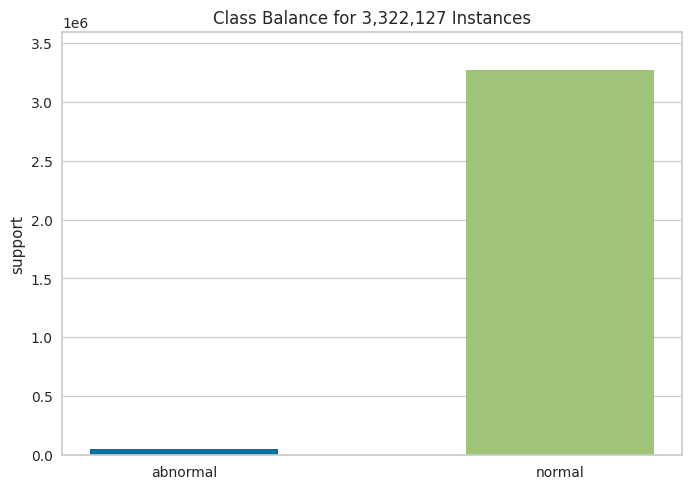

ClassBalance(ax=<Axes: title={'center': 'Class Balance for 3,322,127 Instances'}, ylabel='support'>)

In [38]:
class_balance(df['Target'])

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(df['Log'], df['Target'], random_state= 23, test_size=0.75,
                                                    stratify=df['Target'])

In [40]:
X_train.shape, Y_train.shape

((1661063,), (1661063,))

In [41]:
df = pd.DataFrame()
df['Log'] = X_train
df['Target'] = Y_train
df.reset_index(inplace=True)
df.drop(['index'], axis = 1,inplace= True)
df.head()

,Log,Target
0,1120932567 2005.07.09 R02-M1-N4-C:J15-U11 200...,normal
1,1120090465 2005.06.29 R16-M1-N2-C:J17-U01 200...,normal
2,1120934148 2005.07.09 R33-M0-NB-C:J15-U01 200...,normal
3,1122143139 2005.07.23 R14-M0-ND-C:J06-U11 200...,normal
4,1120149014 2005.06.30 R30-M1-NE-C:J08-U11 200...,normal


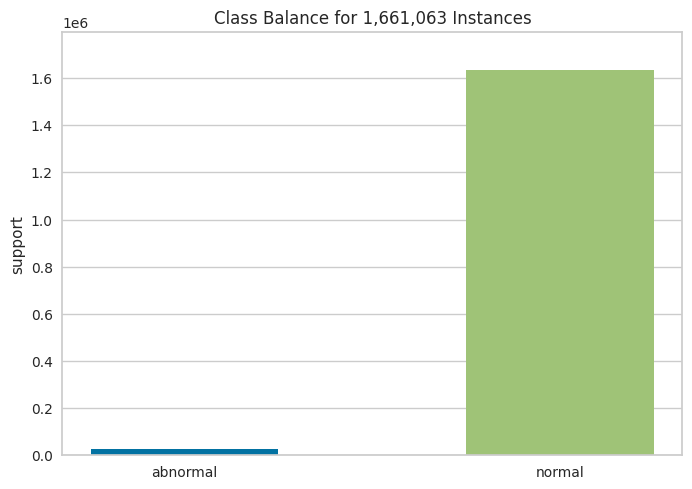

ClassBalance(ax=<Axes: title={'center': 'Class Balance for 1,661,063 Instances'}, ylabel='support'>)

In [42]:
class_balance(df['Target'])

In [43]:
#Exploring a few samples 
samples = list(df.iloc[:5,0])
for doc in samples:
    print(doc)

 1120932567 2005.07.09 R02-M1-N4-C:J15-U11 2005-07-09-11.09.27.875736 R02-M1-N4-C:J15-U11 RAS KERNEL INFO generating core.61412

 1120090465 2005.06.29 R16-M1-N2-C:J17-U01 2005-06-29-17.14.25.376622 R16-M1-N2-C:J17-U01 RAS KERNEL INFO total of 1 ddr error(s) detected and corrected

 1120934148 2005.07.09 R33-M0-NB-C:J15-U01 2005-07-09-11.35.48.241334 R33-M0-NB-C:J15-U01 RAS KERNEL INFO generating core.14160

 1122143139 2005.07.23 R14-M0-ND-C:J06-U11 2005-07-23-11.25.39.232511 R14-M0-ND-C:J06-U11 RAS KERNEL INFO generating core.15178

 1120149014 2005.06.30 R30-M1-NE-C:J08-U11 2005-06-30-09.30.14.489326 R30-M1-NE-C:J08-U11 RAS KERNEL INFO generating core.12310



In [44]:
df.iloc[4,0].split()

['1120149014',
 '2005.06.30',
 'R30-M1-NE-C:J08-U11',
 '2005-06-30-09.30.14.489326',
 'R30-M1-NE-C:J08-U11',
 'RAS',
 'KERNEL',
 'INFO',
 'generating',
 'core.12310']

In [45]:
df["Character_Length"] = df["Log"].str.len()
df["Word_Length"] = df["Log"].str.split().map(lambda x: len(x))
df["Avg Word"] = df["Log"].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x))
df.head()

,Log,Target,Character_Length,Word_Length,Avg Word
0,1120932567 2005.07.09 R02-M1-N4-C:J15-U11 200...,normal,128,10,11.7
1,1120090465 2005.06.29 R16-M1-N2-C:J17-U01 200...,normal,153,16,8.5
2,1120934148 2005.07.09 R33-M0-NB-C:J15-U01 200...,normal,128,10,11.7
3,1122143139 2005.07.23 R14-M0-ND-C:J06-U11 200...,normal,128,10,11.7
4,1120149014 2005.06.30 R30-M1-NE-C:J08-U11 200...,normal,128,10,11.7


In [46]:
print(f"Character Length ranges from {df['Character_Length'].min()} to {df['Character_Length'].max()}")
print(f"Word Length ranges from {df['Word_Length'].min()} to {df['Word_Length'].max()}")

Character Length ranges from 94 to 928
Word Length ranges from 8 to 101


array([[<Axes: title={'center': 'Character_Length'}>,
        <Axes: title={'center': 'Word_Length'}>]], dtype=object)

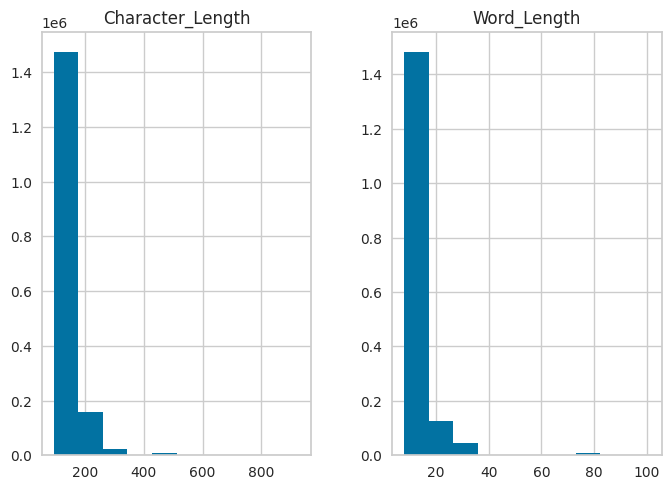

In [47]:
columns = ['Character_Length', 'Word_Length']
df.hist(column=columns, grid=True)

In [48]:
def plot_top_stopwords_barchart(text):
    stop = set(stopwords.words('english'))

    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    from collections import defaultdict
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
    top = sorted(dic.items(), key = lambda x:x [1],reverse=True)[:10]
    x,y = zip(*top)
    plt.bar(x,y)

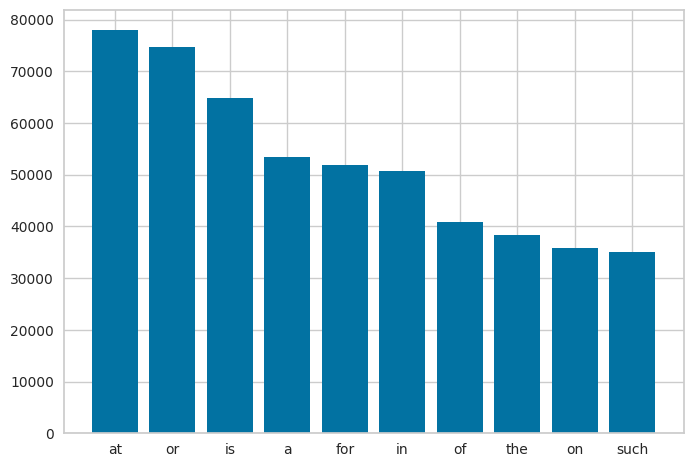

In [49]:
plot_top_stopwords_barchart(df['Log'])

In [50]:
def clean_text(text):
    text = text.lower()
    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    stop_words = set(stopwords.words('english'))
    text = [word for word in text.split() if word not in stop_words and word not in string.punctuation]
    text = ' '.join(word for word in text)
    return text

In [51]:
df['Log'] = df['Log'].apply(clean_text)

In [52]:
df.head()

,Log,Target,Character_Length,Word_Length,Avg Word
0,rmncju rmncju ras kernel info generating core,normal,128,10,11.7
1,rmncju rmncju ras kernel info total ddr errors...,normal,153,16,8.5
2,rmnbcju rmnbcju ras kernel info generating core,normal,128,10,11.7
3,rmndcju rmndcju ras kernel info generating core,normal,128,10,11.7
4,rmnecju rmnecju ras kernel info generating core,normal,128,10,11.7


In [53]:
def plot_top_non_stopwords_barchart(text):
    stop = set(stopwords.words('english'))
    new = text.str.split()
    new = new.values.tolist()
    corpus =[word for i in new for word in i ]
    counter = collections.Counter(corpus)
    most = counter.most_common()
    x, y =[], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    sns.barplot(x=y,y=x)

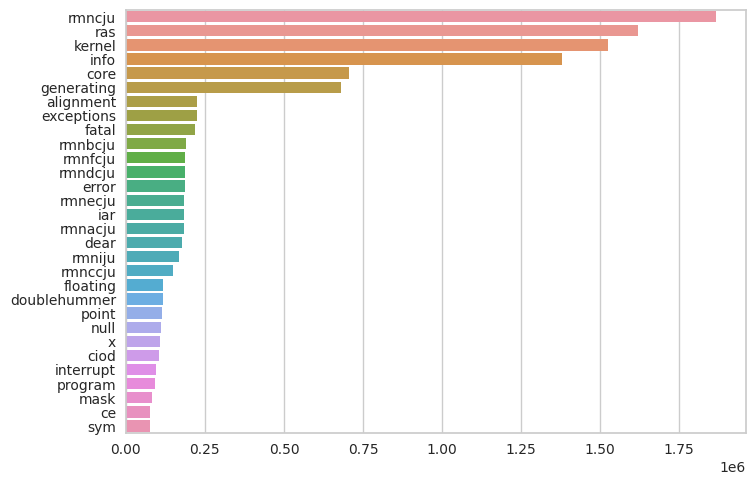

In [54]:
plot_top_non_stopwords_barchart(df['Log'])

In [55]:
def plot_top_word_grams_barchart(text, no_grams = 2):
    stop = set(stopwords.words("english"))
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range =(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0,idx])
                      for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]
    top_n_bigrams= _get_top_ngram(text, no_grams)[:10]
    x,y = map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

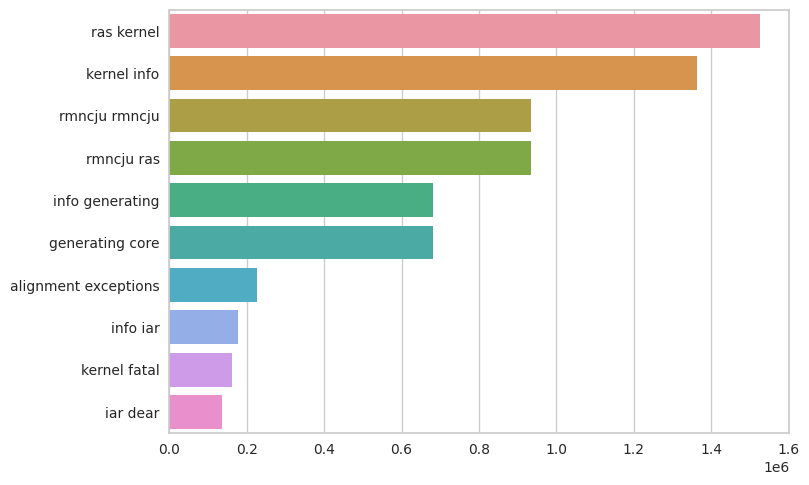

In [56]:
plot_top_word_grams_barchart(df['Log'])